## Spec3Pipeline for MRS   (MIRI MRS CALSPEC3)

`Spec3Pipeline` combines the calibrated data from multiple exposures (e.g. a dither/nod pattern) into a single combined 3D spectral product and a combined 1D spectrum. Before being combined, the exposures receive additional corrections for the purpose of background matching and subtraction, as well as outlier rejection.

Official documentation for `Spec3Pipeline` can be found here:

<https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html>

The `Spec3Pipeline` for MRS comprises a linear series of steps. The steps in order are:

|Step|Description|
|:---|:---|
|`master_background`|subtract master background spectrum created from input exposures or supplied by user|
|`mrs_imatch`|matches image intensities of input MIRI MRS images|
|`outlier_detection`|flag any remaining cosmic-rays or other artifacts left over from previous calibrations|
|`cube_build`|produce 3D spectral cubes from the 'cleaned' 2D detector image|
|`extract_1d`|extract 1D spectrum from 3D cube|


For more information and examples of each of the steps click on the links in the side bar. 

Note that the `master_background` step would normally be run if no background subtraction happened in Spec2Pipeline. However, we will skip the step in this example.

Users of this notebook should be aware that cubes produced will not be perfect and suffer from known issues with MIRISim (oversized MRS PSF, channel 4 flux issues, etc.). Also, the spectral extraction step in the pipeline (extract_1d) does not yet correctly implement the aperture correction factors so the fluxes will be off.

### Input data

An example of running the file through the `Spec3Pipeline` is now shown using a simple simulated fullband, 2-point dither observation of a point source (power law plus emission lines spectrum) with the MIRI MRS produced with [MIRISim v2.3](https://wiki.miricle.org/Public/MIRISim_Public) and brought to level 2B using the `Detector1Pipeline` and `Spec2Pipeline` modules. 

### Python

Start by importing what will be used and set the `CRDS_CONTEXT`

In [1]:
# imports
import os, glob, shutil
import numpy as np
from matplotlib.colors import LogNorm
from cycler import cycler
import matplotlib.pyplot as plt
from subprocess import call
from jwst import datamodels
from jwst.associations.lib.member import Member
from jwst.associations.asn_from_list import asn_from_list

# set the CRDS_CONTEXT
os.environ["CRDS_CONTEXT"] = "jwst_0641.pmap"

`Image3Pipeline` requires an association file as input that lists the exposures to be combined. The content of the association file is printed for inspection. It is assumed they are in 'MRS_science'.

In [2]:
# load the science and background files to lists
my_science_files = glob.glob('MRS_science/*cal.fits')
my_science_files = sorted(my_science_files)

# set the association name
asn_name = 'my_point_source'

# setup an empty level 2 association structure
asn = asn_from_list(my_science_files, product_name=asn_name)

# set some metadata
asn['asn_pool'] = asn_name + '_pool'
asn['asn_type'] = 'spec3'
        
# print the association and save to file
name, ser = asn.dump()
print(ser)

asn_file = asn_name + '_lvl3_asn.json'
with open(asn_file, 'w') as f:
    f.write(ser)

{
    "asn_type": "spec3",
    "asn_rule": "DMS_Level3_Base",
    "version_id": null,
    "code_version": "0.17.1",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "constraints": "No constraints",
    "asn_id": "a3001",
    "target": "none",
    "asn_pool": "my_point_source_pool",
    "products": [
        {
            "name": "my_point_source",
            "members": [
                {
                    "expname": "MRS_science/my_point_source_exposure10_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure11_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure12_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure1_cal.

Import `Spec3Pipeline` and print the docstring to show some information

In [3]:
from jwst.pipeline import Spec3Pipeline
print(Spec3Pipeline.__doc__)


    Spec3Pipeline: Processes JWST spectroscopic exposures from Level 2b to 3.

    Included steps are:
    assign moving target wcs (assign_mtwcs)
    master background subtraction (master_background)
    MIRI MRS background matching (mrs_imatch)
    outlier detection (outlier_detection)
    2-D spectroscopic resampling (resample_spec)
    3-D spectroscopic resampling (cube_build)
    1-D spectral extraction (extract_1d)
    1-D spectral combination (combine_1d)
    


The association file is passed as input. The output files will be saved in `my_output_dir`. 

*Parameters used:*
    
`save_results`: boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; save the results to file
    
`output_dir` : boolean, optional, default is the working directory   
&nbsp;&nbsp;&nbsp;&nbsp; the location to save the output

`steps` : dict, optional, default None  
&nbsp;&nbsp;&nbsp;&nbsp; pass parameters to steps

The `skip` parameters is passed to `master_background' (becuase there is no background in the simulation), `outlier_detection` (due to a bug causing the pipeline to crash) and `skymatch` (which at the moment appears to be overestimating the background resulting in negative fluxes).


In [5]:
# user specified
my_output_dir = 'demo_output'

# the output directory should be created if it doesn't exist
if not os.path.exists(my_output_dir): 
    os.mkdir(my_output_dir)

# run the pipeline
Spec3Pipeline.call(asn_file, save_results=True, output_dir=my_output_dir, 
                   steps={'master_background': {'skip': True},
                          'outlier_detection': {'skip': True},
                          'mrs_imatch': {'skip': True}})


2020-10-29 12:21:17,528 - CRDS - ERROR -  Error determining best reference for 'pars-assignmtwcsstep'  =   Unknown reference type 'pars-assignmtwcsstep'
2020-10-29 12:21:20,642 - CRDS - ERROR -  Error determining best reference for 'pars-masterbackgroundstep'  =   Unknown reference type 'pars-masterbackgroundstep'
2020-10-29 12:21:23,751 - CRDS - ERROR -  Error determining best reference for 'pars-mrsimatchstep'  =   Unknown reference type 'pars-mrsimatchstep'
2020-10-29 12:21:26,880 - CRDS - ERROR -  Error determining best reference for 'pars-outlierdetectionstep'  =   Unknown reference type 'pars-outlierdetectionstep'
2020-10-29 12:21:29,889 - CRDS - ERROR -  Error determining best reference for 'pars-resamplespecstep'  =   Unknown reference type 'pars-resamplespecstep'
2020-10-29 12:21:33,045 - CRDS - ERROR -  Error determining best reference for 'pars-cubebuildstep'  =   Unknown reference type 'pars-cubebuildstep'
2020-10-29 12:21:36,113 - CRDS - ERROR -  Error determining best ref

2020-10-29 12:22:19,052 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2020-10-29 12:22:19,056 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2020-10-29 12:22:19,382 - stpipe.Spec3Pipeline.cube_build - INFO - Step cube_build running with args (<ModelContainer>,).
2020-10-29 12:22:19,384 - stpipe.Spec3Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's3d', 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'band', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 0.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_

2020-10-29 12:30:54,040 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    39  20.00   0.00004545   0.13000000  -2.53499991   2.53499991
2020-10-29 12:30:54,040 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)
2020-10-29 12:30:54,041 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3  1091   1.00   6.42050008   0.00100000   6.42000008   7.51100013
2020-10-29 12:30:54,042 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 1, long
2020-10-29 12:30:54,043 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: my_point_source_ch1-long_s3d.fits
2020-10-29 12:30:54,444 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7703 with wavelength below 6.419500076270197
2020-10-29 12:30:54,444 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 11127 with wavelength above 7.511500128137413
2020-10-29 12:30:54,496 - stpipe.Spec3Pi

2020-10-29 12:41:42,494 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    45  23.00   0.00002886   0.17000000  -3.82500004   3.82500004
2020-10-29 12:41:42,495 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    37  19.00  -0.00013414   0.17000000  -3.14500003   3.14500003
2020-10-29 12:41:42,496 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)
2020-10-29 12:41:42,496 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   855   1.00  10.03099973   0.00200000  10.02999973  11.73999981
2020-10-29 12:41:42,497 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 2, long
2020-10-29 12:41:42,498 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: my_point_source_ch2-long_s3d.fits
2020-10-29 12:41:42,854 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 8411 with wavelength below 10.028999732923694
2020-10-29 12:41:42,855 - stpipe.Spec3Pipeline.cube_build - IN

2020-10-29 12:53:56,598 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)
2020-10-29 12:53:56,599 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    47  24.00  -0.00013548   0.20000000  -4.70000007   4.70000007
2020-10-29 12:53:56,599 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    41  21.00  -0.00007256   0.20000000  -4.10000006   4.10000006
2020-10-29 12:53:56,600 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)
2020-10-29 12:53:56,601 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   877   1.00  15.44149958   0.00300000  15.43999958  18.07099960
2020-10-29 12:53:56,601 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 3, long
2020-10-29 12:53:56,602 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: my_point_source_ch3-long_s3d.fits
2020-10-29 12:53:56,995 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector 

2020-10-29 13:04:18,288 - stpipe.Spec3Pipeline.cube_build - INFO - Number of bands in cube: 1
2020-10-29 13:04:18,855 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:
2020-10-29 13:04:18,856 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)
2020-10-29 13:04:18,856 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    35  18.00   0.00006629   0.34999999  -6.12499990   6.12499990
2020-10-29 13:04:18,857 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    29  15.00  -0.00013666   0.34999999  -5.07499991   5.07499991
2020-10-29 13:04:18,857 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)
2020-10-29 13:04:18,858 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   741   1.00  23.89299939   0.00600000  23.88999939  28.33599943
2020-10-29 13:04:18,859 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 4, long
2020-10-29 13:04:18

2020-10-29 13:07:49,294 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_apcorr_0006.fits
2020-10-29 13:07:49,334 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS
2020-10-29 13:07:49,334 - stpipe.Spec3Pipeline.extract_1d - INFO - Setting use_source_posn to False for source type EXTENDED
2020-10-29 13:07:49,335 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = EXTENDED


False 3.9721757086029103e-13


2020-10-29 13:07:51,536 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json
2020-10-29 13:07:51,539 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_apcorr_0006.fits
2020-10-29 13:07:51,578 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS
2020-10-29 13:07:51,579 - stpipe.Spec3Pipeline.extract_1d - INFO - Setting use_source_posn to False for source type EXTENDED
2020-10-29 13:07:51,579 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = EXTENDED


False 3.9721757086029103e-13


2020-10-29 13:07:54,060 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json
2020-10-29 13:07:54,062 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_apcorr_0006.fits
2020-10-29 13:07:54,104 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS
2020-10-29 13:07:54,105 - stpipe.Spec3Pipeline.extract_1d - INFO - Setting use_source_posn to False for source type EXTENDED
2020-10-29 13:07:54,105 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = EXTENDED


False 3.9721757086029103e-13


2020-10-29 13:07:55,559 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json
2020-10-29 13:07:55,562 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_apcorr_0006.fits
2020-10-29 13:07:55,602 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS
2020-10-29 13:07:55,602 - stpipe.Spec3Pipeline.extract_1d - INFO - Setting use_source_posn to False for source type EXTENDED
2020-10-29 13:07:55,603 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = EXTENDED


False 6.792656142896652e-13


2020-10-29 13:07:57,266 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json
2020-10-29 13:07:57,268 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_apcorr_0006.fits
2020-10-29 13:07:57,307 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS
2020-10-29 13:07:57,308 - stpipe.Spec3Pipeline.extract_1d - INFO - Setting use_source_posn to False for source type EXTENDED
2020-10-29 13:07:57,309 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = EXTENDED


False 6.792656142896652e-13


2020-10-29 13:07:59,244 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json
2020-10-29 13:07:59,247 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_apcorr_0006.fits
2020-10-29 13:07:59,285 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS
2020-10-29 13:07:59,286 - stpipe.Spec3Pipeline.extract_1d - INFO - Setting use_source_posn to False for source type EXTENDED
2020-10-29 13:07:59,286 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = EXTENDED


False 6.792656142896652e-13


2020-10-29 13:08:00,766 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json
2020-10-29 13:08:00,768 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_apcorr_0006.fits
2020-10-29 13:08:00,804 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS
2020-10-29 13:08:00,805 - stpipe.Spec3Pipeline.extract_1d - INFO - Setting use_source_posn to False for source type EXTENDED
2020-10-29 13:08:00,806 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = EXTENDED


False 9.401600280189515e-13


2020-10-29 13:08:02,489 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json
2020-10-29 13:08:02,491 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_apcorr_0006.fits
2020-10-29 13:08:02,528 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS
2020-10-29 13:08:02,529 - stpipe.Spec3Pipeline.extract_1d - INFO - Setting use_source_posn to False for source type EXTENDED
2020-10-29 13:08:02,530 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = EXTENDED


False 9.401600280189515e-13


2020-10-29 13:08:04,481 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json
2020-10-29 13:08:04,484 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_apcorr_0006.fits
2020-10-29 13:08:04,520 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS
2020-10-29 13:08:04,521 - stpipe.Spec3Pipeline.extract_1d - INFO - Setting use_source_posn to False for source type EXTENDED
2020-10-29 13:08:04,521 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = EXTENDED


False 9.401600280189515e-13


2020-10-29 13:08:05,545 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json
2020-10-29 13:08:05,548 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_apcorr_0006.fits
2020-10-29 13:08:05,587 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS
2020-10-29 13:08:05,588 - stpipe.Spec3Pipeline.extract_1d - INFO - Setting use_source_posn to False for source type EXTENDED
2020-10-29 13:08:05,589 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = EXTENDED


False 2.8792399019336705e-12


2020-10-29 13:08:06,776 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json
2020-10-29 13:08:06,779 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_apcorr_0006.fits
2020-10-29 13:08:06,817 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS
2020-10-29 13:08:06,818 - stpipe.Spec3Pipeline.extract_1d - INFO - Setting use_source_posn to False for source type EXTENDED
2020-10-29 13:08:06,819 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = EXTENDED


False 2.8792399019336705e-12


2020-10-29 13:08:08,318 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in demo_output/my_point_source_ch1-short_x1d.fits


False 2.8792399019336705e-12


2020-10-29 13:08:08,412 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in demo_output/my_point_source_ch1-medium_x1d.fits
2020-10-29 13:08:08,501 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in demo_output/my_point_source_ch1-long_x1d.fits
2020-10-29 13:08:08,592 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in demo_output/my_point_source_ch2-short_x1d.fits
2020-10-29 13:08:08,681 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in demo_output/my_point_source_ch2-medium_x1d.fits
2020-10-29 13:08:08,771 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in demo_output/my_point_source_ch2-long_x1d.fits
2020-10-29 13:08:08,860 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in demo_output/my_point_source_ch3-short_x1d.fits
2020-10-29 13:08:08,953 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in demo_output/my_point_source_ch3-medium_x1d.fits
2020-10-29 13:08:09,045 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in demo_output/my

We can plot the combined cubes in each MRS sub-band

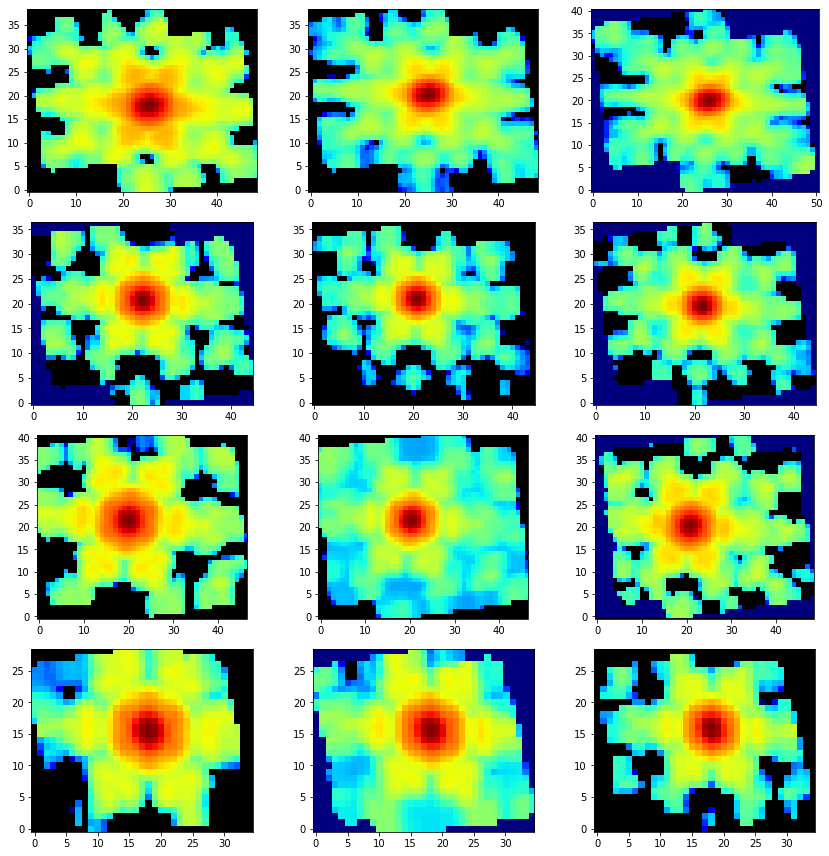

In [10]:
cube_files = glob.glob(os.path.join(my_output_dir, '*s3d.fits'))
cube_files = sorted(cube_files)

fig, axs = plt.subplots(4, 3, figsize=(12, 12))
axs = axs.ravel()

for n, c in enumerate(cube_files):
    cdm = datamodels.open(c)
    axs[n].imshow(np.sum(cdm.data[200:-200], axis=0), cmap='jet', interpolation='nearest', 
                  origin='lower', norm=LogNorm())
    axs[n].set_facecolor('black')
    
plt.tight_layout()
plt.show()

Since we have set the source type to 'POINT' above, the extract_1d step will use an aperture extraction and subtract a background with default values. The aperture centre is at pixel x/2, y/2, the radius is y/4, and the background annulus is from the radius to the radius*sqrt(2). In the future, more advanced extraction methods are planned. One can set also the aperture properties using a custom aperture reference file. Please contact pkavanagh@cp.dias.ie if you want to do this.

We can also plot the spectra. Note that an additional aperture correction factor for the encircled energy in the aperture should also be applied but we forego this here since the CDPs are currently not available.

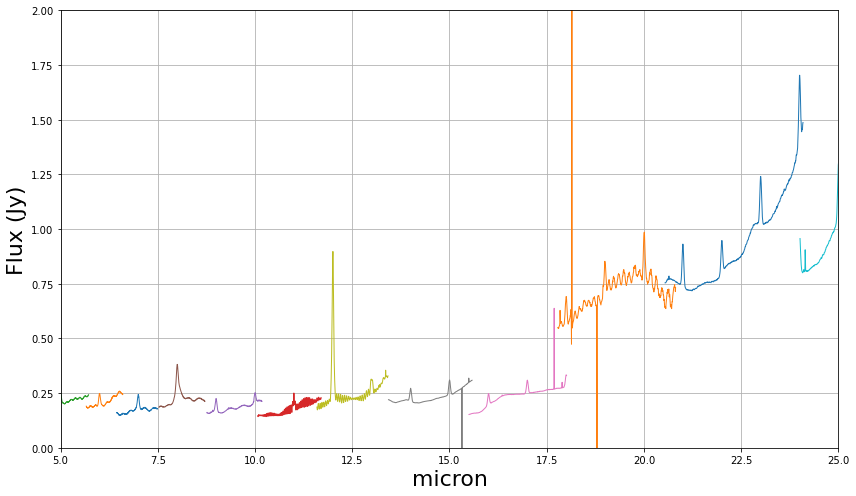

In [7]:
spec_files = glob.glob(os.path.join(my_output_dir, '*1d.fits'))
spec_files = sorted(spec_files)

fig, axs = plt.subplots(1, 1, figsize=(12, 7))
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'm', 'c', 'y'])))

for n, s in enumerate(spec_files):
    sdm = datamodels.open(s)
    axs.plot(sdm.spec[0].spec_table['WAVELENGTH'][20:-20],
                sdm.spec[0].spec_table['FLUX'][20:-20], marker='.', markersize=0,
                linestyle='-', linewidth=1)

axs.set_ylabel(r'Flux (Jy)', fontsize=22)
axs.set_ylim(0, 2)
axs.set_xlim(5, 25)

axs.set_xlabel('micron', fontsize=22)
axs.grid()

plt.tight_layout()
plt.show()

### Command line

To achieve the same result from the command line there are a couple of options. However, one must still generate the association file. In this case, it is best to copy the template above into a text file and save it to `my_point_source_lvl3_asn.json`. The content is printed here for convenience.

```python
{
    "asn_type": "spec3",
    "asn_rule": "DMS_Level3_Base",
    "version_id": null,
    "code_version": "0.13.7",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "constraints": "No constraints",
    "asn_id": "a3001",
    "target": "none",
    "asn_pool": "my_point_source_pool",
    "products": [
        {
            "name": "my_point_source",
            "members": [
                {
                    "expname": "MRS_science/my_point_source_exposure10_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure11_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure12_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure1_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure2_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure3_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure4_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure5_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure6_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure7_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure8_photom.fits",
                    "exptype": "science"
                },
                {
                    "expname": "MRS_science/my_point_source_exposure9_photom.fits",
                    "exptype": "science"
                }
            ]
        }
    ]
}
```

**Option 1:**
Run the `Spec3Pipeline` class using the `strun` command:

```bash
mkdir demo_output

strun jwst.pipeline.Spec3Pipeline my_point_source_lvl3_asn.json --output_dir demo_output --steps.master_background.skip True --steps.outlier_detection.skip True --steps.mrs_imatch.skip True 
```

This will produce the same output file in the user-defined `--output_dir`


**Option 2:**
Collect the pipeline configuration files in your working directory (if they are not already there) using `collect_pipeline_configs` and then run the `Spec3Pipeline` using the `strun` command with the associated `calwebb_spec3.cfg` file. This option is a little more flexible as one can create edit the cfg files, use them again, etc.

```bash
mkdir demo_output

collect_pipeline_cfgs cfgs/

strun cfgs/calwebb_spec3.cfg my_point_source_lvl3_asn.json --output_dir demo_output --steps.master_background.skip True --steps.outlier_detection.skip True --steps.mrs_imatch.skip True
```

This will produce the same output file in the user-defined `--output_dir`

## Further examples

Other notebooks with more complex examples can be found here:

*To be added*